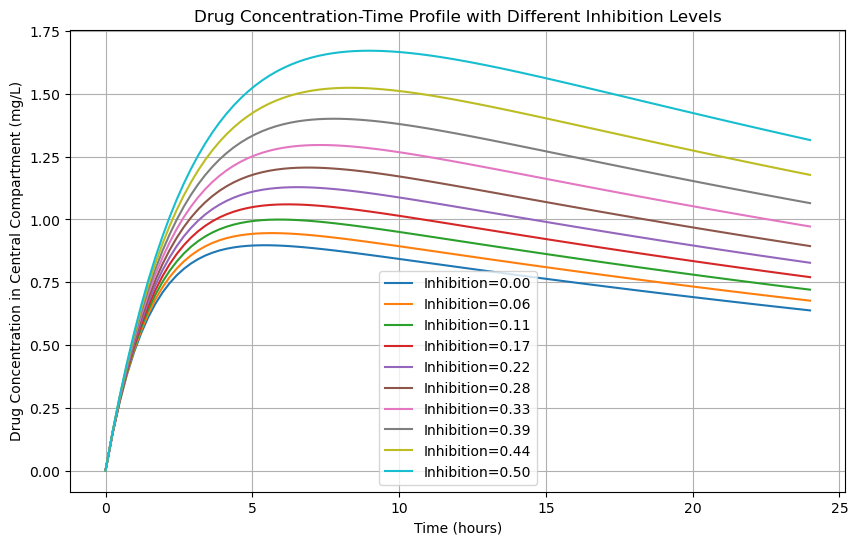

Inhibition=0.00, AUC=18.10, Cmax=0.90
Inhibition=0.06, AUC=19.10, Cmax=0.95
Inhibition=0.11, AUC=20.22, Cmax=1.00
Inhibition=0.17, AUC=21.48, Cmax=1.06
Inhibition=0.22, AUC=22.91, Cmax=1.13
Inhibition=0.28, AUC=24.53, Cmax=1.21
Inhibition=0.33, AUC=26.40, Cmax=1.30
Inhibition=0.39, AUC=28.57, Cmax=1.40
Inhibition=0.44, AUC=31.13, Cmax=1.52
Inhibition=0.50, AUC=34.17, Cmax=1.67


In [10]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt

# Define the Antimony model
model = '''
model one_compartment_pk_model
    // Parameters for drug movement
    dose = 100 milligram;           # Initial dose (mg)
    infusiontime = 10 hour;
    k_a0 = dose / infusiontime;     # Zero-order absorption rate (mg/h)
    k_a1 = 0.02 per_hour;           # First-order absorption rate constant (1/h)
    
    CL_base = 2 per_hour;           # Baseline clearance (L/h)
    Vcentral = 3 litre;             # Volume of central compartment (L)
    Vdepot = 1 litre;               # Volume of depot compartment (L)
    
    // Covariate effect on clearance
    Covariate = 1;                 # Covariate multiplier (e.g., could represent renal function)
    
    // Inhibition effect on clearance
    Inhibition = 0;                # Inhibition fraction (0 = no inhibition, 1 = full inhibition)
    
    // Adjusted clearance incorporating covariate and inhibition
    CL := CL_base * Covariate * (1 - Inhibition);

    // Define compartments
    compartment Central, Depot;
    Central := Vcentral;  # Central compartment volume
    Depot := Vdepot;      # Depot compartment volume

    // Define species
    species Drug_Central in Central, Drug_Depot in Depot;

    // Initial conditions
    Drug_Central = 0 milligram_per_litre;   # Initial drug concentration in central compartment
    Drug_Depot = dose / Vdepot;             # Initial drug concentration in depot compartment

    // Reactions for drug movement
    Absorption: Drug_Depot -> Drug_Central; k_a1 * Drug_Depot;  // First-order absorption
    Clearance: Drug_Central -> ; CL * Drug_Central;             # Elimination
    
    // Output
    A_central := Drug_Central * Vcentral;  # Amount of drug in the central compartment (mg)
    
end
'''

# Define simulation parameters
time_end = 24  # Simulation time (hours)
num_points = 100  # Number of time points

# Simulate the model for a range of inhibition scenarios by altering the Inhibition parameter
inhibition_values = np.linspace(0, 0.5, 10)  # Range from no inhibition to full inhibition
covariate_value = 1.0  # Can adjust this to simulate different covariate effects
results = []

r = te.loada(model)

for inhibition in inhibition_values:
    r.resetAll()
    r["Inhibition"] = inhibition
    r["Covariate"] = covariate_value  # Apply covariate effect (e.g., representing renal function)
    result = r.simulate(0, time_end, num_points)
    results.append((inhibition, result))

# Plotting the results
plt.figure(figsize=(10, 6))

for inhibition, result in results:
    plt.plot(result['time'], result['[Drug_Central]'], label=f'Inhibition={inhibition:.2f}')

plt.xlabel('Time (hours)')
plt.ylabel('Drug Concentration in Central Compartment (mg/L)')
plt.title('Drug Concentration-Time Profile with Different Inhibition Levels')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Print AUC and Cmax for each simulation
for inhibition, result in results:
    AUC_central = np.trapz(result['[Drug_Central]'], result['time'])
    Cmax_central = np.max(result['[Drug_Central]'])
    print(f'Inhibition={inhibition:.2f}, AUC={AUC_central:.2f}, Cmax={Cmax_central:.2f}')